# Machine learning model to read reviews

Question: how can we analyze a large number or reviews with NPL?

Goal: enable companies to quickly extract the key topics covered from the customer feedback without having to read through them one by one

In [1]:
# Import dependencies
from sqlalchemy import create_engine
import pandas as pd
import spacy

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns


#Libraries for lemmatization
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import FreqDist

#Libraries for word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

In [2]:
# Postgres username, password, and database name

POSTGRES_ADDRESS = 'mypostgresdb.cwuhtytzosg8.us-east-2.rds.amazonaws.com' 
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'root' 
POSTGRES_PASSWORD = 'FsM7eA9C4F' ## CHANGE THIS TO YOUR PANOPLY/POSTGRES PASSWORD
POSTGRES_DBNAME = 'my_data_class_db'
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
.format(username=POSTGRES_USERNAME,
password=POSTGRES_PASSWORD,
ipaddress=POSTGRES_ADDRESS,
port=POSTGRES_PORT,
dbname=POSTGRES_DBNAME))
# Create the connection
cnx = create_engine(postgres_str)

In [3]:
# 3 Load database for sentiment/topic analysis
df = pd.read_sql_query('''SELECT * FROM airmattress_cleaned''', con=cnx)
df.head()

,customer_id,review_id,star_rating,review_headline,review_body
0,51982153,R1DZ76NBD2TX55,5,my wife and i had to pick one of these up over...,my wife and i had to pick one of these up over...
1,44662747,R3G4HN08IK8Q5W,5,this is big and comfortable it inflatesdeflat...,this is big and comfortable it inflatesdeflat...
2,17097525,R1S3TBZK71L487,1,horrible it was so comfortable for the first f...,horrible it was so comfortable for the first f...
3,29924839,R9P8YG335IDYV,5,we bought this so our friends kids would have ...,we bought this so our friends kids would have ...
4,46198682,R5VTP1LCQIATH,4,this bed exceeded my expectations in sturdines...,this bed exceeded my expectations in sturdines...


### Prepare data for ML model

In [4]:
# 4 function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count", color = 'black')
  ax.set(ylabel = 'Count')
  plt.show()

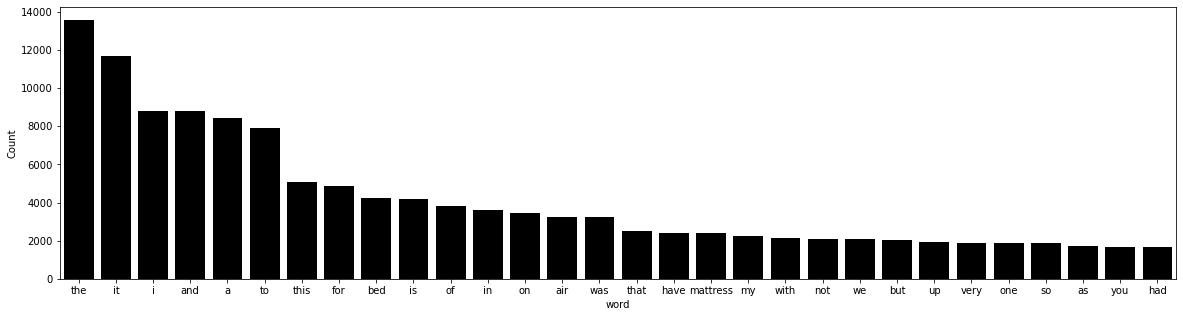

In [5]:
freq_words(df['review_body'])

In [6]:
# 5 Remove unwanted characters, numbers and symbols
df['review_body'] = df['review_body'].str.replace("[^a-zA-Z#]", " ")
df

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,customer_id,review_id,star_rating,review_headline,review_body
0,51982153,R1DZ76NBD2TX55,5,my wife and i had to pick one of these up over...,my wife and i had to pick one of these up over...
1,44662747,R3G4HN08IK8Q5W,5,this is big and comfortable it inflatesdeflat...,this is big and comfortable it inflatesdeflat...
2,17097525,R1S3TBZK71L487,1,horrible it was so comfortable for the first f...,horrible it was so comfortable for the first f...
3,29924839,R9P8YG335IDYV,5,we bought this so our friends kids would have ...,we bought this so our friends kids would have ...
4,46198682,R5VTP1LCQIATH,4,this bed exceeded my expectations in sturdines...,this bed exceeded my expectations in sturdines...
...,...,...,...,...,...
4748,10221632,R2K0TL4VNH71AB,5,good buy very little leak the bed itself is ve...,good buy very little leak the bed itself is ve...
4749,52922779,R3FMSB7NVM64SP,5,this is a great thing to have the built in pum...,this is a great thing to have the built in pum...
4750,45643821,R3JPX7JXE4JF61,5,this air mattress is incredible we bought it ...,this air mattress is incredible we bought it ...
4751,14464916,R2XZEVT9OE0BXI,4,i have not had this item for very long and hav...,i have not had this item for very long and hav...


In [7]:
# 6 Remove stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# Remove short words (length < 3)
df['review_body'] = df['review_body'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# Exclude stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['review_body']]

In [8]:
# To remove noise from reviews, use lemmatization from spaCy library
!python -m spacy download en_core_web_sm 

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2021-05-06 16:08:44.042027: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-05-06 16:08:44.042051: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
# 7 Use nlp to remove words that are not aggregating to analysis, using only adjectives
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
def lemmatization(texts, tags=['ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

In [10]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['big', 'comfortable', 'inflatesdeflates', 'unfoldfold', 'hope', 'lasts', 'long', 'time']


In [11]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

['big', 'comfortable', 'long']


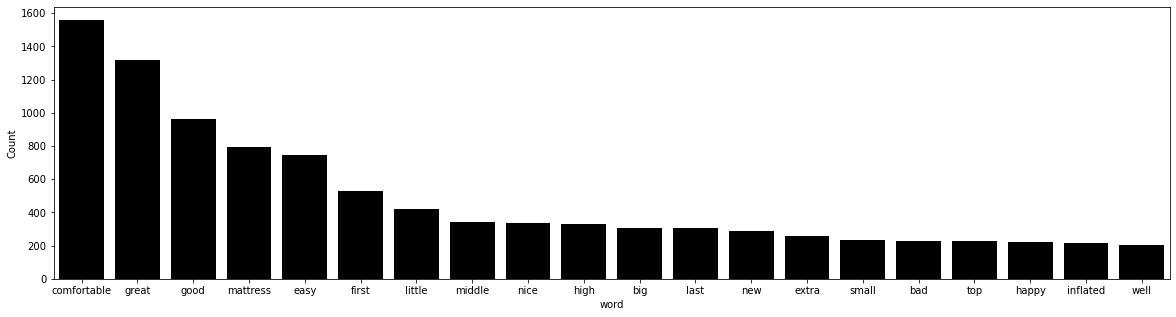

In [12]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 20)